In [1]:
import sys
import pathlib as pl
sys.path.insert(0,str(pl.Path("../").absolute()))

In [2]:
from utils.data_loader import load_data

In [9]:
data_temp, data_wind = load_data()
display(data_temp.head(3))
display(data_wind.head(3))

,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:42,526487,467544,442
1,2022-01-22 13:53:44,526542,467315,461
2,2022-01-22 13:53:45,526532,466868,466


,timestamp,differential_potential_CH1,differential_potential_CH2,transpiration
0,2022-01-22 13:53:37,505940,507749,621
1,2022-01-22 13:53:38,505846,507807,632
2,2022-01-22 13:53:40,505990,507764,629


In [57]:
data = data_temp.set_index("timestamp")
data = data["transpiration"][:30000]
q = data.quantile(0.1)
data = data[data > q]

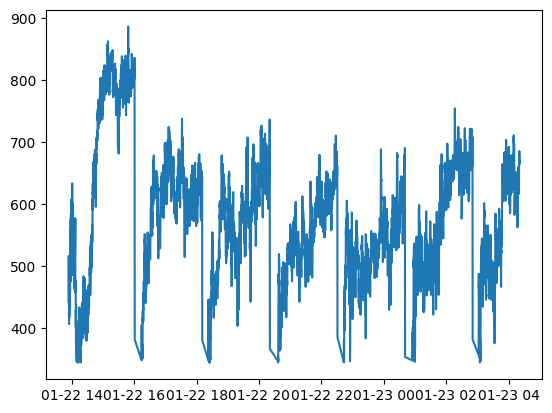

In [59]:
import matplotlib.pyplot as plt

plt.plot(data)

In [60]:
data.to_csv("../data/preprocessed/timeseries.csv")